In [2]:
import pandas as pd
import requests
import numpy as np
from scipy import optimize
import math
import json
import matplotlib.pyplot as plt
import arviz as az
import datetime

# Data

In [3]:
try:
    print('Using local data')
    data_original = pd.read_csv('gc_activitydata_ryan.csv')
except:
    print('Using GC API')
    data_original = pd.read_csv(
        'http://localhost:12021/Ryan%20Duecker?metrics=Duration,TSS,StrydStress,Average_Heart_Rate,Max_Heartrate,Average_Power,\
Athlete_Weight,Estimated_VO2MAX,10_sec_Peak_Pace_Swim,xPace,Pace,IsoPower,Power_Index&\
metadata=VO2max_detected,Shoes,Workout_Code,Workout_Title,Indoor,Frame,Sport'
    )
    data_original.columns = [x.strip(' "') for x in data_original.columns]

    data_original['Sport'] = np.where(data_original['StrydStress']>0
                                 ,'Run'
                                 ,np.where(data_original['Average_Power']>0
                                     ,'Bike'
                                     ,np.where(data_original['10_sec_Peak_Pace_Swim']>0
                                         ,'Swim'
                                         ,'Other')))
    data_original['VO2max_detected'] = data_original['VO2max_detected'].astype(float)
    data_original.to_csv('gc_activitydata_ryan.csv', index=False)

Using local data


# Analysis
___
## Helper Functions

In [4]:
athlete_statics = {"max_hr":191
                  ,"resting_hr":40}

In [185]:
def pre_process(data_df, performance_fxn, performance_lower_bound=0, sport=False):
    data_df['xPace'] = np.where(data_df['xPace'] <= 0, data_df['Pace'], data_df['xPace'])
    data_df = data_df[~(((data_df['Sport'] == 'Run') & (data_df['Pace'] <= 0))
               | ((data_df['Sport'] == 'Bike') & (data_df['Average_Power'] <= 0))
               | (data_df['Average_Heart_Rate'] <= 0))].copy()
    data_df.rename(columns={'date':'workoutDate'}, inplace=True)
    data_df['day_TSS'] = data_df['TSS'].groupby(data_df['workoutDate']).transform('sum').fillna(0)
    data_df['performance_metric'] = data_df.apply(lambda row: performance_fxn(row, athlete_statics), axis=1)
    # data_df['performance_metric'] = np.where(data_df['Duration'] < 60*60, 0, data_df['performance_metric'])
    data_df['performance_metric'] = np.where(data_df['performance_metric'] < performance_lower_bound, 0, data_df['performance_metric'])
    
    # data_df = data_df[['workoutDate','day_TSS','performance_metric','Sport']]

    data_df['performance_metric'] = data_df['performance_metric'].replace(0,np.nan)
    data_df['performance_metric'] = data_df['performance_metric'].fillna(method='ffill')
    agg_dict = {'day_TSS':'mean','performance_metric':'max'}
    if sport:
        agg_dict.update({'Sport':'first'})
        data_df = data_df.sort_values('Sport')
    data_df = data_df.groupby('workoutDate').agg(agg_dict)
    
    data_df['date'] = data_df.index
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df = data_df.sort_values(by=['date'])
    data_df.index = pd.DatetimeIndex(data_df['date'])
    missing_dates = pd.date_range(start=data_df.index.min(), end=data_df.index.max())
    data_df = data_df.reindex(missing_dates, fill_value=0)
    data_df['performance_metric'] = data_df['performance_metric'].replace(0,np.nan)
    data_df['performance_metric'] = data_df['performance_metric'].fillna(method='ffill')
    data_df = data_df.dropna()
    return data_df

In [186]:
def calc_vo2(row, athlete_statics):
    if row['Sport'] == 'Bike':
        percent_vo2 = (row['Average_Heart_Rate'] - athlete_statics["resting_hr"])/(athlete_statics["max_hr"] - athlete_statics["resting_hr"])
        vo2_estimated = (((row['Average_Power']/75)*1000)/row['Athlete_Weight']) / percent_vo2
    elif row['Sport'] == 'Run':
        percent_vo2 = (row['Average_Heart_Rate'] - athlete_statics["resting_hr"])/(athlete_statics["max_hr"] - athlete_statics["resting_hr"])
        vo2_estimated = (210/row['xPace']) / percent_vo2
    else:
        vo2_estimated =  0
    return vo2_estimated

def use_garmin_vo2(row, athlete_statics):
    vo2_estimated = 0
    if (row['Workout_Code'] != 'Rec') & (row['Sport'] in ['Run','Bike']):
        vo2_estimated = row['VO2max_detected'] # Garmin VO2 Estimation
    return vo2_estimated

def calc_ae_ef(row, athlete_statics):
    ef = 0
    if (row['Workout_Code'] == 'AE'):
        if row['Sport'] == 'Bike':
            ef = row['IsoPower']/row['Average_Heart_Rate']
        elif row['Sport'] == 'Run':
            ef = 0 # row['IsoPower']/row['Average_Heart_Rate']
    return ef

def use_power_index(row, athlete_statics):
    if row['Average_Power'] > 0:
        val = row['Power_Index']
    else:
        val = 0
    return val

performance_fxns = [calc_vo2, use_garmin_vo2, calc_ae_ef, use_power_index]

## Check weekly readout

In [170]:
# data = data_original[data_original['Sport'] == 'Bike'].copy()
# data = pre_process(data, performance_fxn=calc_ae_ef, performance_lower_bound=0)

# data = data.reset_index()
# data['week_start']  = data['index'].apply(lambda day_instance: day_instance - datetime.timedelta(days=day_instance.day_of_week))
# data.set_index('index', inplace=True)

# summary_data = data.groupby(['week_start']).agg({'day_TSS':'sum','performance_metric':'max'})
# # summary_data = summary_data[:-1]
# fig, ax = plt.subplots(2,1, figsize=(10,8), dpi=100)
# ax[0].bar(summary_data.index, summary_data['day_TSS'])
# ax0_1 = ax[0].twinx()
# ax0_1.scatter(summary_data.index, summary_data['performance_metric'], s=5, label='performance_metric est.', color='red')
# ax0_1.plot(summary_data.index, summary_data['performance_metric'], ls='-', lw=1, color='red')

# ax[1].bar(data.index, data['day_TSS'])
# ax1_1 = ax[1].twinx()
# ax1_1.scatter(data.index, data['performance_metric'], s=5, label='performance_metric est.', color='red')
# ax1_1.plot(data.index, data['performance_metric'], ls='-', lw=1, color='red')

## Scipy Solver
___
### Settings & Model Functions

In [197]:
class banister(object):
    def __init__(self, params=[0.1, 0.5, 50, 45, 7], ctlatl_start=0):
        self.params = params
        self.ctls = []
        self.atls = []
        self.ctlatl_start = [ctlatl_start]
    
    def model(self, load_metric, params=[]):
        if len(params) != 5:
            params = self.params
        self.params = params
        
        self.ctls = self.atls = self.ctlatl_start # why?
        Banister_Predictions = np.array([])
        for i in range(len(load_metric)):
            ctl = (load_metric[i] * (1-math.exp(-1/params[3]))) + (self.ctls[i] * (math.exp(-1/params[3])))
            atl = (load_metric[i] * (1-math.exp(-1/params[4]))) + (self.atls[i] * (math.exp(-1/params[4])))
            self.ctls.append(ctl)
            self.atls.append(atl)
            Banister_Predictions = np.append(Banister_Predictions, params[2] + params[0]*ctl - params[1]*atl)

        return Banister_Predictions

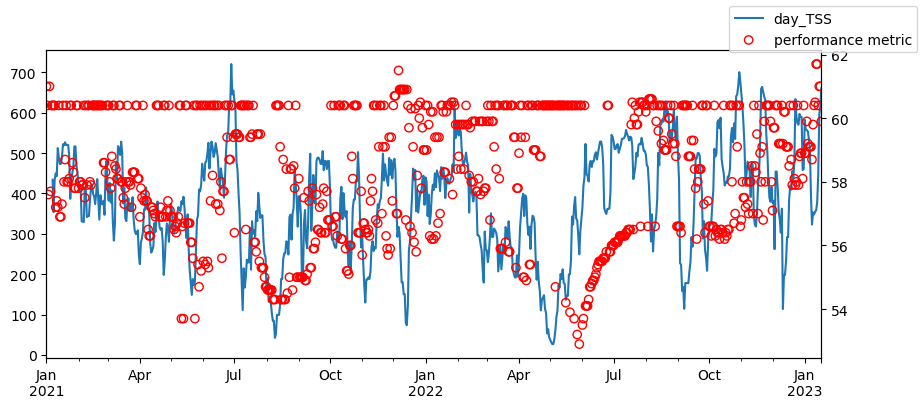

In [198]:
max_hr = 185
resting_hr = 40
ctls_ref = 42
atls_ref = 7
performance_fxn = performance_fxns[1]


data = data_original[((data_original['date'].str.contains('2021'))
                    | (data_original['date'].str.contains('2022'))
                    | (data_original['date'].str.contains('2023')))
                    # & (data_original['Sport'] == 'Bike')
                    ].copy()
# data = data_original.copy()
data = pre_process(data, performance_fxn=performance_fxn)
load_metric = data['day_TSS'].to_numpy()
performance_metric = data['performance_metric'].to_numpy()
fig, ax = plt.subplots(figsize=(10,4))
data['day_TSS'].rolling(window=7).sum().plot(ax=ax)
ax2 = ax.twinx()
ax2.scatter(data.index
            ,data['performance_metric']
            ,marker='o'
            ,edgecolor='red'
            ,facecolor='none'
            ,label='performance metric'
            )
fig.legend()

### Execute Model

In [199]:
bm = banister()

def optimize_banister(params):    
    losses = []

    Banister_Predictions = bm.model(load_metric, params=params)
    
    losses = abs(performance_metric - Banister_Predictions)
    MAE = np.mean(losses)
    return MAE

initial_guess  = [0.1, 0.5, 50, 45, 10]
individual_banister_model = optimize.minimize(optimize_banister
                                            ,x0=initial_guess
                                                #     k1,       k2,       p0,     CTLS,   ATLS
                                            ,bounds=[(.1,.90),(.1,.90),(20,80),(30,60),(5,20)]
                                            # ,method='Nelder-Mead'
                                            ,tol=1e-8
                                            )
print(individual_banister_model)
for val in individual_banister_model['x']:
    print(val)

      fun: 1.7419045792309542
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.00123473e-02,  2.36048048e-01, -1.33870681e-03,  1.75370814e-04,
       -2.19733102e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 348
      nit: 27
     njev: 58
   status: 0
  success: True
        x: array([ 0.12327795,  0.1       , 58.33954567, 44.92769271, 11.04809839])
0.12327794743293938
0.1
58.339545671176154
44.927692705463166
11.048098385777763


### Assess accuracy of model

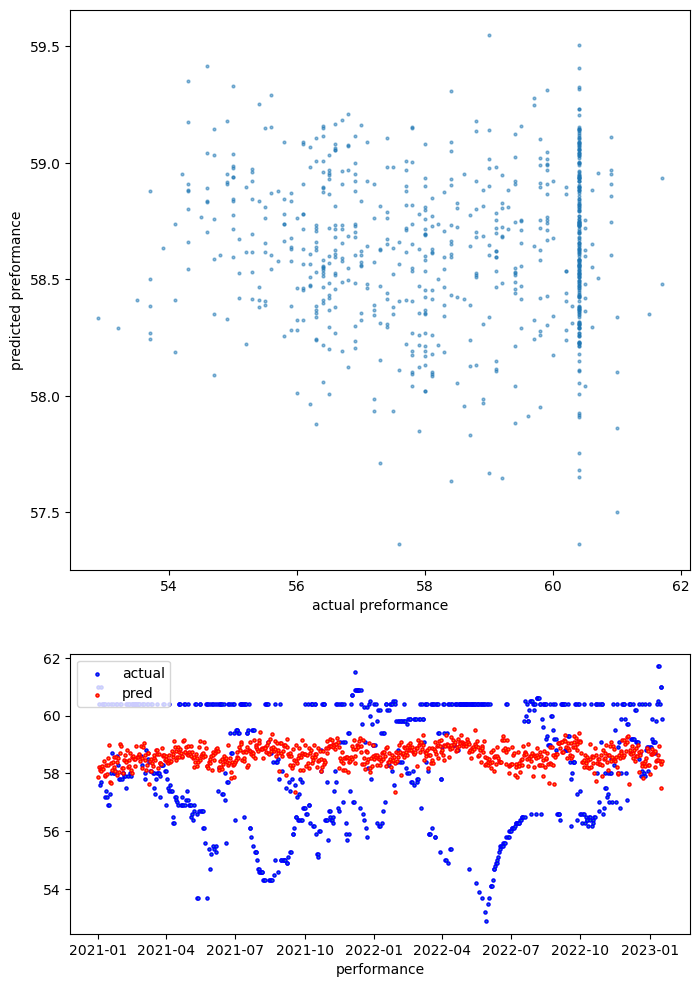

In [200]:
load_metric = data['day_TSS'].tolist()
data['pred performance_metric'] = bm.model(load_metric)

## Plot
fig, ax = plt.subplots(2,1, figsize=(8,12), dpi=100,  gridspec_kw={'height_ratios': [2, 1]})
ax[0].scatter(x=data['performance_metric']
          ,y=data['pred performance_metric']
          ,s=4
          ,alpha=.5)
ax[0].set_xlabel('actual preformance')
ax[0].set_ylabel('predicted preformance')

ax[1].scatter(data.index
             ,data['performance_metric']
             ,label='actual'
             ,facecolor=None
             ,edgecolor='blue'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].scatter(data.index
             ,data['pred performance_metric']
             ,label='pred'
             ,facecolor=None
             ,edgecolor='red'
             ,s=5
             ,linewidths=1
             ,marker='o')
ax[1].set_xlabel('date')
ax[1].set_xlabel('performance')
ax[1].legend(loc=2)

## Bayes Solver

In [ ]:
import pymc as pm
from pymc import HalfCauchy, Model, Normal, sample, Uniform, Beta

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [ ]:
data = data_original[data_original['Sport'] == 'Run'].copy()
data = pre_process(data, performance_fxn=use_garmin_vo2)
    
TSS = data['day_TSS'].tolist()
performance_kpi = data['performance_metric'].tolist()

def banister_regression(TSS, performance_kpi):
    with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
        # Define priors
        sigma = Normal("sigma", 0, sigma=5)

        p0 = Normal("p0", 55, sigma=7)
        ctls_mu = Normal("ctls_mu", 42, 4)
        atls_mu = Normal("atls_mu", 7, 2)
        ctls_sigma = Normal("ctls_sigma", 8, 4)
        atls_sigma = Normal("atls_sigma", 4, 2)
        ctls = Normal("ctls", ctls_mu, sigma=ctls_sigma) #6
        atls = Normal("atls", atls_mu, sigma=atls_sigma) #2.5
        
        k1 = Beta("k1", alpha=1, beta=5) # guess == 0.1
        k2 = Beta("k2", alpha=3, beta=3) # guess == 0.5

        # Define likelihood
        banister_prediction = Normal("banister_prediction",
                                     mu=(p0 
                                         + k1 * (TSS * 1-pm.math.exp(-1/ctls))
                                         - k2 * (TSS * 1-pm.math.exp(-1/atls))
                                        )
                                    ,sigma=sigma
                                    ,observed=performance_kpi)
    return model

In [ ]:
banister_model = banister_regression(TSS=TSS, performance_kpi=performance_kpi)

In [ ]:
with banister_model:
    fit = pm.sample(2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p0, ctls_mu, atls_mu, ctls_sigma, atls_sigma, ctls, atls, k1, k2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 334 seconds.


[Text(0.5, 1.0, 'Sigma Posterior'), Text(0.5, 0, 'Sigma')]

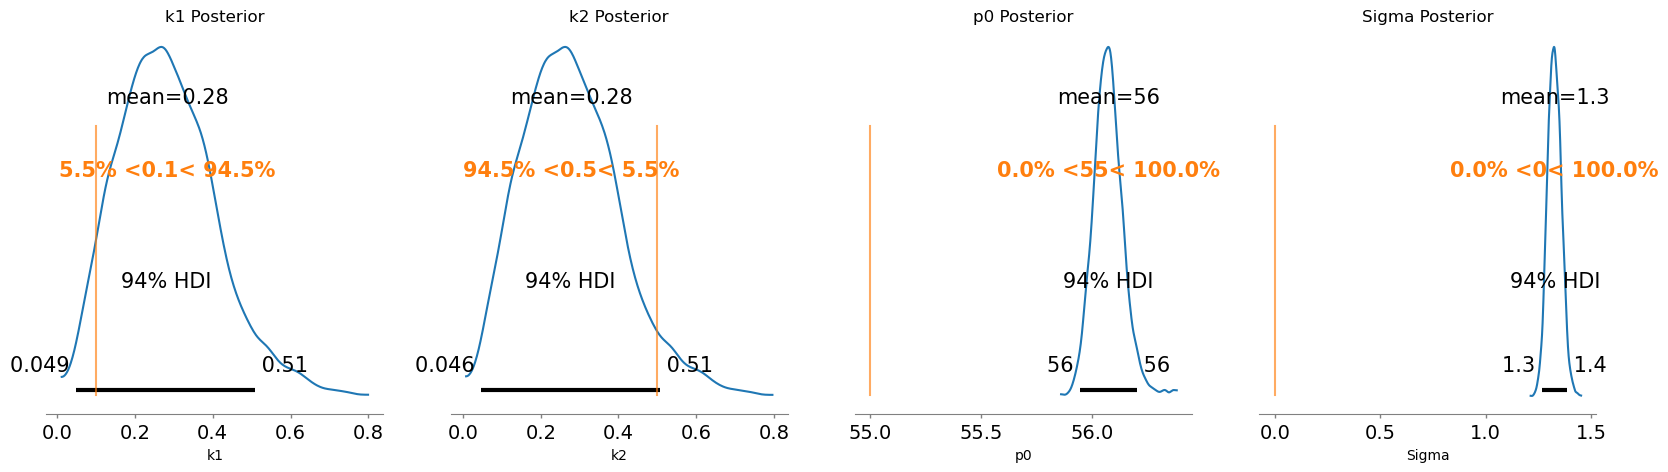

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

az.plot_posterior(fit, var_names=["k1"], ref_val=.1, ax=ax[0])
ax[0].set(title="k1 Posterior", xlabel="k1")

az.plot_posterior(fit, var_names=["k2"], ref_val=.5, ax=ax[1])
ax[1].set(title="k2 Posterior", xlabel="k2")

az.plot_posterior(fit, var_names=["p0"], ref_val=55, ax=ax[2])
ax[2].set(title="p0 Posterior", xlabel="p0")

az.plot_posterior(fit, var_names=["sigma"], ref_val=0, ax=ax[3])
ax[3].set(title="Sigma Posterior", xlabel="Sigma")

[Text(0.5, 1.0, 'ATLS Posterior'), Text(0.5, 0, 'ATLS')]

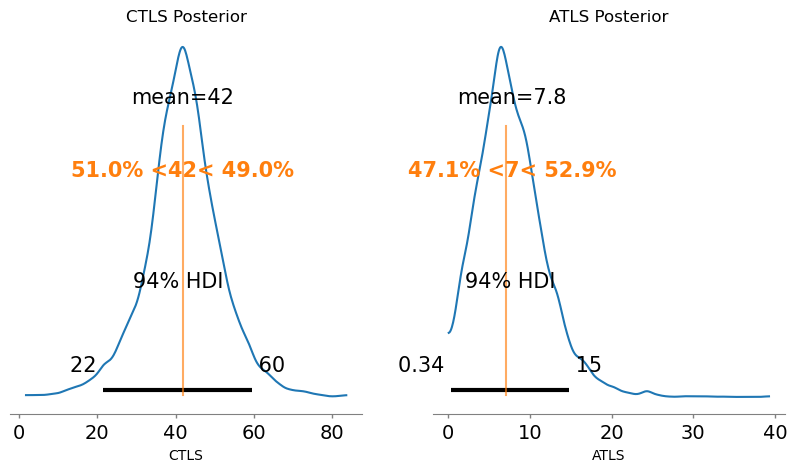

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

az.plot_posterior(fit, var_names=["ctls"], ref_val=ctls_ref, ax=ax[0])
ax[0].set(title="CTLS Posterior", xlabel="CTLS")

az.plot_posterior(fit, var_names=["atls"], ref_val=atls_ref, ax=ax[1])
ax[1].set(title="ATLS Posterior", xlabel="ATLS")